<a href="https://colab.research.google.com/github/rashmi-2000/AI-Generated-Art/blob/main/Cycle_GAN_real_art.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cycle GAN

In [ ]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git #Keras for instance_normalization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-obbojrod
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-obbojrod
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101077 sha256=9262c6065372e2be5dfc362eb6e38b9a0338e5aa7c04bf9be4120061a3f04e6b
  Stored in directory: /tmp/pip-ephem-wheel-cache-0xeiuikj/wheels/bb/1f/f2/b57495012683b6b20bbae94a3915ec79753111452d79886abc
Successfully built keras-contrib


In [ ]:
import cv2

Unsharp Mask Sharpening Technique


In [ ]:
#Unsharp Mask
def unsharp(image):
  gaussian_3 = cv2.GaussianBlur(image, (0, 0), 2.0)
  unsharp_image = cv2.addWeighted(image, 2.0, gaussian_3, -1.0, 0)
  return unsharp_image

Laplacian Filter Sharpening Technique

In [ ]:
#Unsharp Mask
import numpy as np
def lapfil(path):
  kernel = np.array([[0, -1, 0],
                    [-1, 5,-1],
                    [0, -1, 0]])
  image_sharp = cv2.filter2D(src=path, ddepth=-1, kernel=kernel)
  return image_sharp

Highboost Filter

In [ ]:
#Highboost Filter
import numpy as np
from matplotlib import pyplot as plt
import imageio
def highboost(path):
    kernel = np.array([[-1, -1, -1],
                   [-1,  8, -1],
                   [-1, -1, -1]])
    image_hpf = cv2.filter2D(path, -1, kernel)
    return image_hpf

In [ ]:
#accessing dataset from Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization  #instance_normalization
from matplotlib import pyplot

#DISCRIMINATOR (classifying real/fake using instance normalization)
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
 
	# source image input
	in_image = Input(shape=image_shape)
 
	# C64: 4x4 kernel Stride 2x2 and 64 filters
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	d = LeakyReLU(alpha=0.2)(d)
 
	# C128: 4x4 kernel Stride 2x2 and 128 filters
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)#LeakyReLU

	# C256: 4x4 kernel Stride 2x2 and 256 filters
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
 
	# C512: 4x4 kernel Stride 2x2 and 512 filters
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
 
	# second last output layer : 4x4 kernel but Stride 1x1
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
 
	# patch output
	patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
 
	# define model
	model = Model(in_image, patch_out)
	model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
	return model

#resnet block is needed as a part of generator
def resnet_block(n_filters, input_layer):
	# weight initialization
	init = RandomNormal(stddev=0.02)
 
	# first convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
 
	# second convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
 
	# concatenate merge channel-wise with input layer
	g = Concatenate()([g, input_layer]) #concatenate output with input
	return g

#GENERATOR
def define_generator(image_shape, n_resnet=9):
	# weight initialization
	init = RandomNormal(stddev=0.02)
 
	# image input
	in_image = Input(shape=image_shape)
 
	# c7s1-64
	g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
 
	# d128
	g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
 
	# d256
	g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
 
	# R256
	for _ in range(n_resnet):
		g = resnet_block(256, g) #9 resnet blocks
	
	# u128
	g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
 
	# u64
	g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
 
	# c7s1-3
	g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	out_image = Activation('tanh')(g) #tanh -> -1 to 1
 
	# define model
	model = Model(in_image, out_image)
	return model
 
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):

#All other models should be constant or non-trainable when  1 model is training
	g_model_1.trainable = True
	d_model.trainable = False
	g_model_2.trainable = False
  
	#4 losses

	#adversarial loss
	input_gen = Input(shape=image_shape)
	gen1_out = g_model_1(input_gen)
	output_d = d_model(gen1_out)
 
	#identitiy loss
	input_id = Input(shape=image_shape)
	output_id = g_model_1(input_id)
 
	#Forward cycle consistency loss
	output_f = g_model_2(gen1_out)
 
	#Backward cycle consistency loss
	gen2_out = g_model_2(input_id)
	output_b = g_model_1(gen2_out)
    
	#define model graph
	model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
	
#defining the optimizer-> Adam solver
	opt = Adam(lr=0.0002, beta_1=0.5)
 
 #compile mode weighting of L1(MAE) and L2(MSE) loss [minimizing the losses]
	model.compile(loss=['mse', 'mae', 'mae', 'mae'], 
               loss_weights=[1, 5, 10, 10], optimizer=opt)
	return model

#Helper Functions
#1
#load and prepare training images
def load_real_samples(filename):

	#load dataset
	data = load(filename)
 
 #unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']

	# scale from [0,255] to [-1,1] (tanh)
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

#2
#select a batch of random samples, returns  images and target. (real images- (y)- 1)
def generate_real_samples(dataset, n_samples, patch_shape):

	#choose random instance
	ix = randint(0, dataset.shape[0], n_samples)
 
	#retrieve selected image
	X = dataset[ix]

	#generate real class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return X, y

#3
#select a batch of random samples, returns  images and target. (fake images- (y)- 0)
def generate_fake_samples(g_model, dataset, patch_shape):
	
	#generate fake images
	X = g_model.predict(dataset)
	
	#fake class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

#4
def save_models(step, g_model_AtoB, g_model_BtoA):

	#saves first generator model
	filename1 = '/content/drive/MyDrive/Project/CycleGAN/TrainedModels/C_Highboost_Real_Model/g_model_AtoB_%06d.h5' % (step+1)
	g_model_AtoB.save(filename1)
 
	#saves second generator model
	filename2 = '/content/drive/MyDrive/Project/CycleGAN/TrainedModels/C_Highboost_Real_Model/g_model_BtoA_%06d.h5' % (step+1)
	g_model_BtoA.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

#5
#periodically generate images using the save model and plot imput and output images
def summarize_performance(step, g_model, trainX, name, n_samples=5):

	#select a sample of i/p img
	X_in, _ = generate_real_samples(trainX, n_samples, 0)
 
	#generate translated image
	X_out, _ = generate_fake_samples(g_model, X_in, 0)
 
	#scale all pixels from (-1, 1) to (0,1)
	X_in = (X_in + 1) / 2.0
	X_out = (X_out + 1) / 2.0
	
	#plot real image
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_in[i])
	
	#plot translated image
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_out[i])
	
	#save plot
	filename1 = '%s_generated_plot_%06d.png' % (name, (step+1))
	pyplot.savefig(filename1)
	pyplot.close()
 
 #5
#pool of 50 fake images to reduce model oscillation
def update_image_pool(pool, images, max_size=50):
	selected = list()
	for image in images:
		if len(pool) < max_size:
			
			# stack the pool
			pool.append(image)
			selected.append(image)
		elif random() < 0.5:
			selected.append(image)
		else:
			ix = randint(0, len(pool))
			selected.append(pool[ix])
			pool[ix] = image
	return asarray(selected)

#TRAINING THE MODEL
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset, epochs=5):

	# define properties of the training run
	n_epochs, n_batch, = epochs, 1  

	# determine the output square shape of the discriminator
	n_patch = d_model_A.output_shape[1]

	# unpack dataset
	trainA, trainB = dataset

	# prepare image pool for fake images
	poolA, poolB = list(), list()
 
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
 
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
    
# manually enumerate epochs
	for i in range(n_steps):

		# select a batch of real samples from each domain (A and B)
		X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
		X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
	
		# generate a batch of fake samples using both B to A and A to B generators.
		X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
		X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
	
		# update fake images in the pool. Remember that the paper suggstes a buffer of 50 images
		X_fakeA = update_image_pool(poolA, X_fakeA)
		X_fakeB = update_image_pool(poolB, X_fakeB)
        
		# update generator B->A via the composite model
		g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
	
		# update discriminator for A -> [real/fake]
		dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
		dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
		
    # update generator A->B via the composite model 
		g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
	
		# update discriminator for B -> [real/fake]
		dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
		dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
		
		print('Iteration>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
	
		# evaluate the model performance periodically
     #If batch size (total images)=100, performance will be summarized after every 75th iteration.
		if (i+1) % (bat_per_epo * 1) == 0:

			# plot A->B translation
			summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
			# plot B->A translation

			summarize_performance(i, g_model_BtoA, trainB, 'BtoA')
		if (i+1) % (bat_per_epo * 5) == 0:

			# save the models
			save_models(i, g_model_AtoB, g_model_BtoA)

Dataset Preprocessing

In [ ]:
import os
from os import listdir
import re
import cv2

In [ ]:
fd1 = '/content/drive/MyDrive/WarpedDreams/CycleGAN/Dataset/realistic_car'
fd2='/content/drive/MyDrive/WarpedDreams/CycleGAN/Dataset/sketch_car'

In [ ]:

data=dict()
for images in os.listdir(fd1):
  iml=list()
  if images.endswith(".jpg"):
    img=images[:-4]
    for ima in os.listdir(fd2):
      if ima.endswith(".png") and ima.startswith(img):
        iml.append(ima)
    data[images]=iml
data 


{'n02958343_10092-1.jpg': ['n02958343_10092-1.png'],
 'n02958343_10092-2.jpg': ['n02958343_10092-2.png'],
 'n02958343_10092-3.jpg': ['n02958343_10092-3.png'],
 'n02958343_10092-4.jpg': ['n02958343_10092-4.png'],
 'n02958343_10092-5.jpg': ['n02958343_10092-5.png'],
 'n02958343_10187-1.jpg': ['n02958343_10187-1.png'],
 'n02958343_10187-2.jpg': ['n02958343_10187-2.png'],
 'n02958343_10187-3.jpg': ['n02958343_10187-3.png'],
 'n02958343_10187-4.jpg': ['n02958343_10187-4.png'],
 'n02958343_10187-5.jpg': ['n02958343_10187-5.png'],
 'n02958343_1104-1.jpg': ['n02958343_1104-1.png'],
 'n02958343_1104-2.jpg': ['n02958343_1104-2.png'],
 'n02958343_1104-3.jpg': ['n02958343_1104-3.png'],
 'n02958343_1104-4.jpg': ['n02958343_1104-4.png'],
 'n02958343_1104-5.jpg': ['n02958343_1104-5.png'],
 'n02958343_11246-1.jpg': ['n02958343_11246-1.png'],
 'n02958343_11246-2.jpg': ['n02958343_11246-2.png'],
 'n02958343_11246-3.jpg': ['n02958343_11246-3.png'],
 'n02958343_11246-4.jpg': ['n02958343_11246-4.png'],
 'n

UNSHARP 

In [ ]:

# count=0
# trainlen=len(data)*0.8
# for imagesA, imagesB in data.items():
#   count+=1
#   imgA = cv2.imread('/content/drive/MyDrive/Project/CycleGAN/Dataset/realistic_car/'+imagesA, 1)
#   image=imagesB[0]
#   imgB = cv2.imread('/content/drive/MyDrive/Project/CycleGAN/Dataset/sketch_car/'+image, 1)
#   imgB= unsharp(imgB)
#   if count>trainlen:
    
    
#     os.chdir('/content/drive/MyDrive/Project/CycleGAN/Dataset/Test_Train_Split/C_Unsharp_Real_Dataset/testA/')
#     filename=image
#     cv2.imwrite(filename, imgA)
    
    
#     os.chdir('/content/drive/MyDrive/Project/CycleGAN/Dataset/Test_Train_Split/C_Unsharp_Real_Dataset/testB/')
#     filename=image
#     cv2.imwrite(filename, imgB)
  
#   else:
#     os.chdir('/content/drive/MyDrive/Project/CycleGAN/Dataset/Test_Train_Split/C_Unsharp_Real_Dataset/trainA/')
#     filename=image
#     cv2.imwrite(filename, imgA)
    
    
#     os.chdir('/content/drive/MyDrive/Project/CycleGAN/Dataset/Test_Train_Split/C_Unsharp_Real_Dataset/trainB/')
#     filename=image
#     cv2.imwrite(filename, imgB)




LAPLACIAN SHARPENING

In [ ]:
# count=0
# trainlen=len(data)*0.8
# for imagesA, imagesB in data.items():
#   count+=1
#   imgA = cv2.imread('/content/drive/MyDrive/realistic_car/'+imagesA, 1)
#   image=imagesB[0]
#   imgB = cv2.imread('/content/drive/MyDrive/sketch_car/'+image, 1)
#   imgB= lapfil(imgB)
#   if count>trainlen:
    
    
#     os.chdir('/content/drive/MyDrive/Cycle-Laplacian-Data/testA/')
#     filename=image
#     cv2.imwrite(filename, imgA)
    
    
#     os.chdir('/content/drive/MyDrive/Cycle-Laplacian-Data/testB/')
#     filename=image
#     cv2.imwrite(filename, imgB)
  
#   else:
#     os.chdir('/content/drive/MyDrive/Cycle-Laplacian-Data/trainA/')
#     filename=image
#     cv2.imwrite(filename, imgA)
    
    
#     os.chdir('/content/drive/MyDrive/Cycle-Laplacian-Data/trainB/')
#     filename=image
#     cv2.imwrite(filename, imgB)




HIGHBOOST

In [ ]:
# count=0
# trainlen=len(data)*0.8
# for imagesA, imagesB in data.items():
#   count+=1
#   imgA = cv2.imread('/content/drive/MyDrive/Project/CycleGAN/Dataset/realistic_car/'+imagesA, 1)
#   image=imagesB[0]
#   imgB = cv2.imread('/content/drive/MyDrive/Project/CycleGAN/Dataset/sketch_car/'+image, 1)
#   imgB= highboost(imgB)
#   if count>trainlen:
    
    
#     os.chdir('/content/drive/MyDrive/Project/CycleGAN/Dataset/Test_Train_Split/C_Highboost_Real_Dataset/testA/')
#     filename=image
#     cv2.imwrite(filename, imgA)
    
    
#     os.chdir('/content/drive/MyDrive/Project/CycleGAN/Dataset/Test_Train_Split/C_Highboost_Real_Dataset/testB/')
#     filename=image
#     cv2.imwrite(filename, imgB)
  
#   else:
#     os.chdir('/content/drive/MyDrive/Project/CycleGAN/Dataset/Test_Train_Split/C_Highboost_Real_Dataset/trainA/')
#     filename=image
#     cv2.imwrite(filename, imgA)
    
    
#     os.chdir('/content/drive/MyDrive/Project/CycleGAN/Dataset/Test_Train_Split/C_Highboost_Real_Dataset/trainB/')
#     filename=image
#     cv2.imwrite(filename, imgB)




In [ ]:
from os import listdir
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from matplotlib import pyplot as plt
import numpy as np
from sklearn.utils import resample

In [ ]:
def load_images(path, size=(256,256)):
	data_list = list()
	# enumerate filenames in directory, assume all are images
	for filename in listdir(path):

		# load and resize the image
		pixels = load_img(path + filename, target_size=size)
	
		# convert to numpy array
		pixels = img_to_array(pixels)
	
		# store
		data_list.append(pixels)
	return asarray(data_list)

In [ ]:
path = '/content/drive/MyDrive/WarpedDreams/CycleGAN/Dataset/Test_Train_Split/C_Unsharp_Real_Dataset/'
# path = '/content/drive/MyDrive/Project/CycleGAN/Dataset/Test_Train_Split/C_Laplacian_Real_Dataset/'
# path= '/content/drive/MyDrive/Project/CycleGAN/Dataset/Test_Train_Split/C_Highboost_Real_Dataset/'

In [ ]:
dataA_all = load_images(path + 'trainA/')
print('Loaded dataA: ', dataA_all.shape)

Loaded dataA:  (509, 256, 256, 3)


In [ ]:
#subsampling
dataA = resample(dataA_all, 
                 replace=False,     
                 n_samples=80,    
                 random_state=42) 

In [ ]:
dataB_all = load_images(path + 'trainB/')
print('Loaded dataB: ', dataB_all.shape)

Loaded dataB:  (509, 256, 256, 3)


In [ ]:
dataB = resample(dataB_all, 
                 replace=False,     
                 n_samples=80,    
                 random_state=42) 

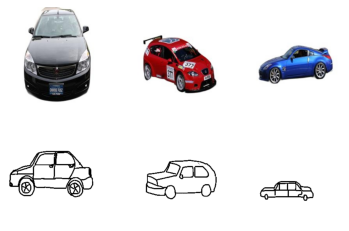

In [ ]:
n_samples = 3
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + i)
	plt.axis('off')
	plt.imshow(dataA[i].astype('uint8'))
 
# plot target image
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + n_samples + i)
	plt.axis('off')
	plt.imshow(dataB[i].astype('uint8'))
plt.show()

In [ ]:
data = [dataA, dataB]
print('Loaded', data[0].shape, data[1].shape)

Loaded (80, 256, 256, 3) (80, 256, 256, 3)


In [ ]:
def preprocess_data(data):
	# load compressed arrays
	# unpack arrays
	X1, X2 = data[0], data[1]
	
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

In [ ]:
dataset = preprocess_data(data)

In [ ]:
image_shape = dataset[0].shape[1:]
# generator: A -> B
g_model_AtoB = define_generator(image_shape)

# generator: B -> A
g_model_BtoA = define_generator(image_shape)

# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)

# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)

# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)

# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
from datetime import datetime 
start1 = datetime.now() 
# train models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset, epochs=25)
stop1 = datetime.now()

#Execution time of the model 
execution_time = stop1-start1
print("Execution time is: ", execution_time)

Iteration>1, dA[1.822,2.258] dB[1.262,1.875] g[27.202,29.487]
Iteration>2, dA[5.020,6.564] dB[1.059,6.491] g[28.168,32.842]
Iteration>3, dA[9.754,6.408] dB[1.251,8.396] g[39.909,26.177]
Iteration>4, dA[1.267,2.825] dB[1.906,8.586] g[36.851,24.078]
Iteration>5, dA[1.273,1.439] dB[1.944,4.362] g[26.881,22.033]
Iteration>6, dA[0.685,0.682] dB[0.847,5.020] g[24.198,20.513]
Iteration>7, dA[0.326,0.437] dB[0.773,1.183] g[22.088,20.914]
Iteration>8, dA[0.431,0.433] dB[0.701,0.898] g[20.413,18.898]
Iteration>9, dA[0.312,0.339] dB[0.484,0.551] g[19.466,18.538]
Iteration>10, dA[0.325,0.385] dB[0.616,0.590] g[21.621,21.070]
Iteration>11, dA[0.437,0.348] dB[0.738,0.550] g[19.207,17.684]
Iteration>12, dA[0.337,0.259] dB[0.535,0.497] g[18.260,16.641]
Iteration>13, dA[0.248,0.254] dB[0.450,0.616] g[18.739,16.677]
Iteration>14, dA[0.346,0.512] dB[0.375,0.650] g[18.555,16.822]
Iteration>15, dA[0.364,0.295] dB[0.478,0.433] g[20.204,19.664]
Iteration>16, dA[0.422,0.299] dB[0.424,0.542] g[18.232,16.687]
I

In [ ]:
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.models import load_model
from matplotlib import pyplot
from numpy.random import randint


In [ ]:
def select_sample(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
 
	# retrieve selected images
	X = dataset[ix]
	return X

In [ ]:
def show_plot_b(imagesX, imagesY1, imagesY2):
	images = vstack((imagesX, imagesY1, imagesY2))
	titles = ['Real', 'Generated', 'Reconstructed']
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0

	# plot images row by row
	for i in range(len(images)):

		# define subplot
		pyplot.subplot(1, len(images), 1 + i)
	
		# turn off axis
		pyplot.axis('off')
	
		# plot raw pixel data
		pyplot.imshow(images[i])
	
		# title
		pyplot.title(titles[i])
	pyplot.show()

In [ ]:
A_data = resample(dataA_all, 
                 replace=False,     
                 n_samples=50,    
                 random_state=42) # reproducible results

B_data = resample(dataB_all, 
                 replace=False,     
                 n_samples=50,    
                 random_state=42) # reproducible results

A_data = (A_data - 127.5) / 127.5
B_data = (B_data - 127.5) / 127.5

In [ ]:
cust = {'InstanceNormalization': InstanceNormalization}
model_AtoB = load_model('/content/drive/MyDrive/WarpedDreams/CycleGAN/TrainedModels/C_Laplacian_Real_Model/g_model_AtoB_004000.h5', cust, compile=False)
model_BtoA = load_model('/content/drive/MyDrive/WarpedDreams/CycleGAN/TrainedModels/C_Laplacian_Real_Model/g_model_BtoA_004000.h5', cust, compile=False)

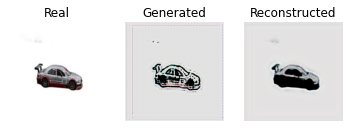

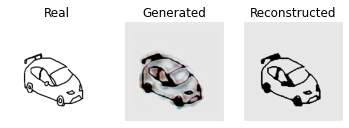

In [ ]:
A_real = select_sample(A_data, 1)
B_generated  = model_AtoB.predict(A_real)
A_reconstructed = model_BtoA.predict(B_generated)
show_plot_b(A_real, B_generated, A_reconstructed)

# plot B->A->B (Sketch to Real to Sketch)
B_real = select_sample(B_data, 1)
A_generated  = model_BtoA.predict(B_real)
B_reconstructed = model_AtoB.predict(A_generated)
show_plot_b(B_real, A_generated, B_reconstructed)


In [ ]:
# test_image = load_img('/content/drive/MyDrive/WarpedDreams/CycleGAN/Dataset/Test_Train_Split/C_Unsharp_Real_Dataset/testA/n02958343_12557-1.png')
# test_image = img_to_array(test_image)
# test_image_input = np.array([test_image])  # Convert single image to a batch.
# test_image_input = (test_image_input - 127.5) / 127.5

# # plot B->A->B (Photo to Monet to Photo)
# monet_generated  = model_BtoA.predict(test_image_input)
# photo_reconstructed = model_AtoB.predict(monet_generated)
# show_plot(test_image_input, monet_generated, photo_reconstructed)

Real

In [ ]:
modelh = load_model('/content/drive/MyDrive/WarpedDreams/CycleGAN/TrainedModels/C_Highboost_Real_Model/g_model_AtoB_002000.h5', cust, compile=False)
modell=load_model('/content/drive/MyDrive/WarpedDreams/CycleGAN/TrainedModels/C_Laplacian_Real_Model/g_model_AtoB_004000.h5', cust, compile=False)
modelu=load_model('/content/drive/MyDrive/WarpedDreams/CycleGAN/TrainedModels/C_Unsharp_Real_Model/g_model_AtoB_002400.h5', cust, compile=False)

In [ ]:
from numpy import vstack
def show_plot(imagesX, imagesY,imagesY1):
	images = vstack((imagesX,imagesY, imagesY1))
	titles = ['Sketch','Real', 'Generated']
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0

	# plot images row by row
	for i in range(len(images)):

		# define subplot
		pyplot.subplot(1, len(images), 1 + i)
	
		# turn off axis
		pyplot.axis('off')
	
		# plot raw pixel data
		pyplot.imshow(images[i])
	
		# title
		pyplot.title(titles[i])
	pyplot.show()

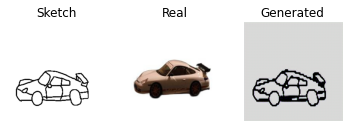

In [ ]:
#unsharp
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
test_image=cv2.imread('/content/drive/MyDrive/WarpedDreams/CycleGAN/Dataset/sketch_car/n02958343_1104-2.png')
test_image=unsharp(test_image)
test_image = img_to_array(test_image)
test_image_input = np.array([test_image])  # Convert single image to a batch.
test_image_input = (test_image_input - 127.5) / 127.5
gen_image = modelu.predict(test_image_input)
image1 = cv2.imread('/content/drive/MyDrive/WarpedDreams/CycleGAN/Dataset/realistic_car/n02958343_1104-2.jpg',1)
image1 = img_to_array(image1)
image1 = np.array([image1])  # Convert single image to a batch.
image1 = (image1 - 127.5) / 127.5
show_plot(test_image_input,image1,gen_image)

In [ ]:
#lap
test_image=cv2.imread('/content/drive/MyDrive/sketch_car/n02958343_14365-3.png')
test_image=lapfil(test_image)
test_image = img_to_array(test_image)
test_image_input = np.array([test_image])  # Convert single image to a batch.
test_image_input = (test_image_input - 127.5) / 127.5
gen_image = modell.predict(test_image_input)
image1 = cv2.imread('/content/drive/MyDrive/realistic_car/n02958343_14365-3.jpg',1)
image1 = img_to_array(image1)
image1 = np.array([image1])  # Convert single image to a batch.
image1 = (image1 - 127.5) / 127.5
show_plot(test_image_input,image1,gen_image)

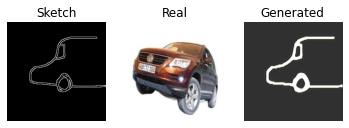

In [ ]:
#Highboost
test_image=cv2.imread('/content/drive/MyDrive/sketch_car/n02958343_14365-3.png')
test_image=highboost(test_image)
test_image = img_to_array(test_image)
test_image_input = np.array([test_image])  # Convert single image to a batch.
test_image_input = (test_image_input - 127.5) / 127.5
gen_image = modelh.predict(test_image_input)
image1 = cv2.imread('/content/drive/MyDrive/realistic_car/n02958343_14365-3.jpg',1)
image1 = img_to_array(image1)
image1 = np.array([image1])  # Convert single image to a batch.
image1 = (image1 - 127.5) / 127.5
show_plot(test_image_input,image1,gen_image)

Abstract

In [ ]:
modelha = load_model('/content/drive/MyDrive/WarpedDreams/CycleGAN/TrainedModels/C_Highboost_Abstract_Model/g_model_AtoB_001600.h5', cust, compile=False)
modella=load_model('/content/drive/MyDrive/WarpedDreams/CycleGAN/TrainedModels/C_Laplacian_Abstract_Model/g_model_AtoB_002000.h5', cust, compile=False)
modelua=load_model('/content/drive/MyDrive/WarpedDreams/CycleGAN/TrainedModels/C_Unsharp_Abstract_Model/g_model_AtoB_002000.h5', cust, compile=False)

In [ ]:
def show_plota(imagesX, imagesY1):
	images = vstack((imagesX, imagesY1))
	titles = ['Real', 'Generated']
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0

	# plot images row by row
	for i in range(len(images)):

		# define subplot
		pyplot.subplot(1, len(images), 1 + i)
	
		# turn off axis
		pyplot.axis('off')
	
		# plot raw pixel data
		pyplot.imshow(images[i])
	
		# title
		pyplot.title(titles[i])
	pyplot.show()

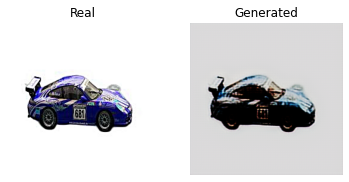

In [ ]:
#unsharp
test_image=cv2.imread('//content/drive/MyDrive/realistic_car/n02958343_10092-5.jpg')
test_image=unsharp(test_image)
test_image = img_to_array(test_image)
test_image_input = np.array([test_image])  # Convert single image to a batch.
test_image_input = (test_image_input - 127.5) / 127.5
gen_image = modelua.predict(test_image_input)

show_plota(test_image_input,gen_image)

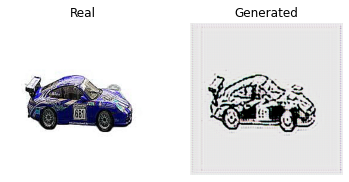

In [ ]:
#lap
test_image=cv2.imread('//content/drive/MyDrive/realistic_car/n02958343_10092-5.jpg')
test_image=lapfil(test_image)
test_image = img_to_array(test_image)
test_image_input = np.array([test_image])  # Convert single image to a batch.
test_image_input = (test_image_input - 127.5) / 127.5
gen_image = modell.predict(test_image_input)
show_plota(test_image_input,gen_image)

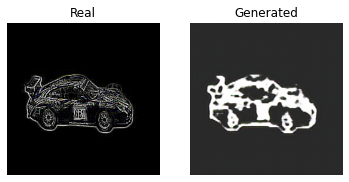

In [ ]:
#Highboost
test_image=cv2.imread('/content/drive/MyDrive/realistic_car/n02958343_10092-5.jpg')
test_image=highboost(test_image)
test_image = img_to_array(test_image)
test_image_input = np.array([test_image])  # Convert single image to a batch.
test_image_input = (test_image_input - 127.5) / 127.5
gen_image = modelh.predict(test_image_input)

show_plota(test_image_input,gen_image)

performance

In [ ]:
from skimage.metrics import structural_similarity as ssim
import numpy as np
import cv2

In [ ]:
def mse(imageA, imageB):
 # the 'Mean Squared Error' between the two images is the sum of the squared difference between the two images
 mse_error = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
 mse_error /= float(imageA.shape[0] * imageA.shape[1])
	
 # return the MSE. The lower the error, the more "similar" the two images are.
 return mse_error

def compare(imageA, imageB):
 # Calculate the MSE and SSIM
 m = mse(imageA, imageB)
 s = ssim(imageA, imageB)

 # Return the SSIM. The higher the value, the more "similar" the two images are.
 return s

In [ ]:
def calculate_metrics(image1, image2):
  # Convert the images to grayscale
  gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
  gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

  # Check for same size and ratio and report accordingly
  ho, wo, _ = image1.shape
  hc, wc, _ = image2.shape
  ratio_orig = ho/wo
  ratio_comp = hc/wc
  dim = (wc, hc)

  if round(ratio_orig, 2) != round(ratio_comp, 2):
    print("\nImages not of the same dimension. Check input.")
    exit()

  # Resize first image if the second image is smaller
  elif ho > hc and wo > wc:
    print("\nResizing original image for analysis...")
    gray1 = cv2.resize(gray1, dim)

  elif ho < hc and wo < wc:
    print("\nCompressed image has a larger dimension than the original. Check input.")
    exit()

  if round(ratio_orig, 2) == round(ratio_comp, 2):
    mse_value = mse(gray1, gray2)
    ssim_value = compare(gray1, gray2)
    print("MSE:", mse_value)
    print("SSIM:", ssim_value)
    return mse_value, ssim_value

  return -1, -1

In [ ]:
def calc_avg_metrics(SSIM):
  #SSIM  are dict to SSIM and MSE values of all test imgs
  val = SSIM.values()
  ssim = sum(val) / len(val)
  return ssim

In [ ]:
from keras.models import load_model
from numpy.random import randint
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img

In [ ]:
cust = {'InstanceNormalization': InstanceNormalization}
model_AtoB = load_model('/content/drive/MyDrive/CycleGAN/TrainedModels/C_Highboost_Real_Model/g_model_AtoB_002000.h5', cust, compile=False)
model_BtoA = load_model('/content/drive/MyDrive/CycleGAN/TrainedModels/C_Highboost_Real_Model/g_model_BtoA_002000.h5', cust, compile=False)

test_image=cv2.imread('/content/drive/MyDrive/CycleGAN/Dataset/Test_Train_Split/C_Highboost_Real_Dataset/testB/n02958343_10092-1.png')
test_image = img_to_array(test_image)
test_image_input = np.array([test_image])  # Convert single image to a batch.
test_image_input = (test_image_input - 127.5) / 127.5
B_generated  = model_AtoB.predict(test_image_input)
nnorm_image = cv2.normalize(B_generated, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
ngen_image = np.array(nnorm_image.astype(np.uint8))
ng=np.reshape(ngen_image,(256,256,3))

image1 = cv2.imread('/content/drive/MyDrive/CycleGAN/Dataset/Test_Train_Split/C_Highboost_Real_Dataset/testA/n02958343_10092-1.png',1)

calculate_metrics(image1)


SSIM: 0.56836475494675105


In [ ]:
cust = {'InstanceNormalization': InstanceNormalization}
model_AtoB = load_model('/content/drive/MyDrive/CycleGAN/TrainedModels/C_Highboost_Real_Model/g_model_AtoB_002000.h5', cust, compile=False)
model_BtoA = load_model('/content/drive/MyDrive/CycleGAN/TrainedModels/C_Highboost_Real_Model/g_model_BtoA_002000.h5', cust, compile=False)

test_image=cv2.imread('/content/drive/MyDrive/CycleGAN/Dataset/Test_Train_Split/C_Highboost_Real_Dataset/testB/n02958343_10092-1.png')
test_image = img_to_array(test_image)
test_image_input = np.array([test_image])  # Convert single image to a batch.
test_image_input = (test_image_input - 127.5) / 127.5
B_generated  = model_AtoB.predict(test_image_input)
nnorm_image = cv2.normalize(B_generated, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
ngen_image = np.array(nnorm_image.astype(np.uint8))
ng=np.reshape(ngen_image,(256,256,3))

image1 = cv2.imread('/content/drive/MyDrive/CycleGAN/Dataset/Test_Train_Split/C_Highboost_Real_Dataset/testA/n02958343_10092-1.png',1)

calculate_metrics(image1)
